In [100]:
pip install arch

Note: you may need to restart the kernel to use updated packages.


ADF Test Statistic: -17.640993301302068
p-value: 3.7589873003265055e-30
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2600.0063158533676
Iteration:      2,   Func. Count:     14,   Neg. LLF: 733670.6774653645
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1058.80386374621
Iteration:      4,   Func. Count:     29,   Neg. LLF: 1009.3075421443268
Iteration:      5,   Func. Count:     35,   Neg. LLF: 985.3254339235216
Iteration:      6,   Func. Count:     41,   Neg. LLF: 982.3372862308306
Iteration:      7,   Func. Count:     46,   Neg. LLF: 982.2719566116996
Iteration:      8,   Func. Count:     51,   Neg. LLF: 982.2626259037983
Iteration:      9,   Func. Count:     56,   Neg. LLF: 982.2600698726044
Iteration:     10,   Func. Count:     61,   Neg. LLF: 982.2600119872529
Iteration:     11,   Func. Count:     66,   Neg. LLF: 982.2600040575386
Iteration:     12,   Func. Count:     71,   Neg. LLF: 982.2599992560426
Iteration:     13,   Func. Count:     75,   Neg. LLF: 982.25999

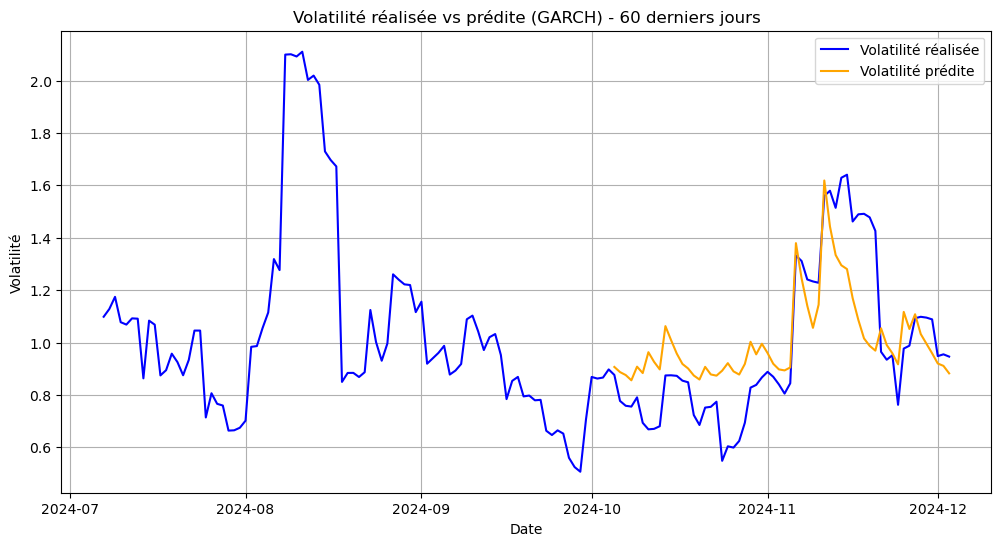

Évaluation des prédictions de volatilité :
Mean Squared Error (MSE): 0.0388
Root Mean Squared Error (RMSE): 0.1971
Mean Absolute Error (MAE): 0.1577
R² Score: 0.5618


In [102]:
import pandas as pd
import numpy as np
from arch import arch_model
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Charger les données
data = pd.read_csv('BTCUSDT_daily_2023.csv')  # Remplacez par votre fichier
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# Calculer les rendements logarithmiques
data['returns'] = np.log(data['close'] / data['close'].shift(1))
data = data.dropna()

# Vérification de stationnarité (ADF Test)
adf_test = adfuller(data['returns'])
print("ADF Test Statistic:", adf_test[0])
print("p-value:", adf_test[1])

# Mise à l'échelle des rendements
scaler = StandardScaler()
data['scaled_returns'] = scaler.fit_transform(data['returns'].values.reshape(-1, 1))

# Ajuster un modèle GARCH(1, 1) sur les rendements mis à l'échelle
model = arch_model(data['scaled_returns'], vol='Garch', p=1, q=1)
garch_fit = model.fit()
print(garch_fit.summary())

# Prédictions de volatilité pour les 60 derniers jours
last_60_returns = data['scaled_returns'][-60:]
forecast = garch_fit.forecast(horizon=1, start=last_60_returns.index[0])
data['predicted_volatility_scaled'] = np.nan
data.loc[forecast.variance.index, 'predicted_volatility_scaled'] = np.sqrt(forecast.variance.values[-60:, 0])


# Calculer la volatilité réalisée pour comparaison
data['realized_volatility'] = data['scaled_returns'].rolling(window=10).std()

# Extraire les données pour la visualisation
data_60_days = data.iloc[-60:]
data_nor = data.iloc[-150:]

# Visualisation des résultats
plt.figure(figsize=(12, 6))
plt.plot(data_nor.index, data_nor['realized_volatility'], label="Volatilité réalisée", color='blue')
plt.plot(data_60_days.index, data_60_days['predicted_volatility_scaled'], label="Volatilité prédite", color='orange')
plt.title("Volatilité réalisée vs prédite (GARCH) - 60 derniers jours")
plt.xlabel("Date")
plt.ylabel("Volatilité")
plt.legend()
plt.grid(True)
plt.show()

# Extraire les 60 derniers jours de volatilité réalisée et prédite
realized_volatility = data_60_days['realized_volatility'].dropna()
predicted_volatility = data_60_days['predicted_volatility_scaled'].dropna()

# Assurez-vous que les indices correspondent
realized_volatility = realized_volatility.loc[predicted_volatility.index]

# Calculer les métriques
mse = mean_squared_error(realized_volatility, predicted_volatility)
rmse = np.sqrt(mse)
mae = mean_absolute_error(realized_volatility, predicted_volatility)
r2 = r2_score(realized_volatility, predicted_volatility)

# Afficher les résultats
print("Évaluation des prédictions de volatilité :")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")



ADF Test Statistic: -53.53088367821622
p-value: 0.0
Iteration:      1,   Func. Count:     10,   Neg. LLF: 331835.7082762541
Iteration:      2,   Func. Count:     24,   Neg. LLF: 93941.14318280443
Iteration:      3,   Func. Count:     34,   Neg. LLF: 19191.40222333053
Iteration:      4,   Func. Count:     44,   Neg. LLF: 17840.56064067995
Iteration:      5,   Func. Count:     54,   Neg. LLF: 20032.697675325508
Iteration:      6,   Func. Count:     64,   Neg. LLF: 16038.453048057856
Iteration:      7,   Func. Count:     74,   Neg. LLF: 14020.688248586383
Iteration:      8,   Func. Count:     84,   Neg. LLF: 9794.232798301642
Iteration:      9,   Func. Count:     94,   Neg. LLF: 10408.858631090034
Iteration:     10,   Func. Count:    104,   Neg. LLF: 9680.177574786465
Iteration:     11,   Func. Count:    113,   Neg. LLF: 9666.245908455932
Iteration:     12,   Func. Count:    122,   Neg. LLF: 9679.828797587976
Iteration:     13,   Func. Count:    132,   Neg. LLF: 9658.43665926815
Iteration

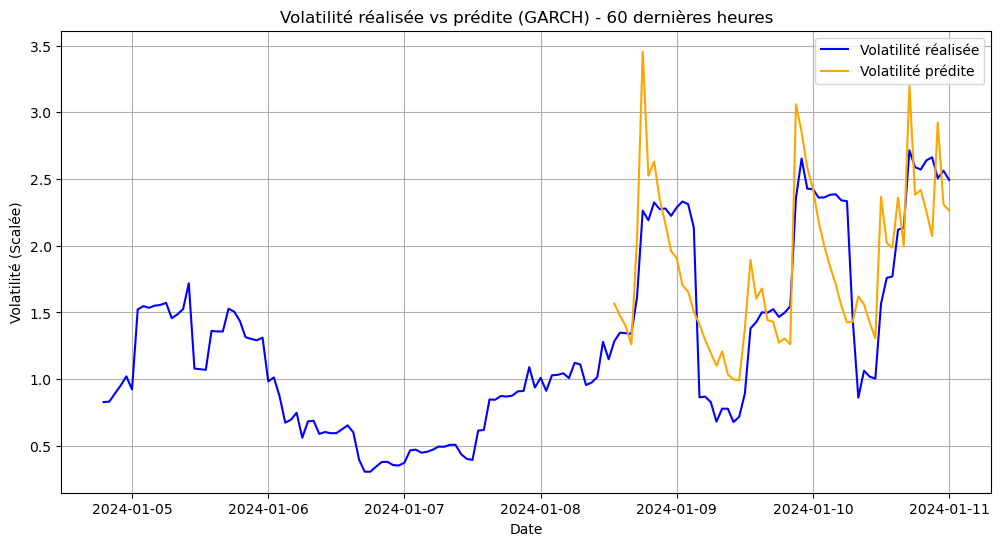

In [32]:
import pandas as pd
import numpy as np
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Charger les données
data = pd.read_csv('BTCUSDT_hourly_2023.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# Calculer les rendements logarithmiques
data['returns'] = np.log(data['close'] / data['close'].shift(1))
data = data.dropna()

# Vérification de stationnarité
adf_test = adfuller(data['returns'])
print("ADF Test Statistic:", adf_test[0])
print("p-value:", adf_test[1])

# Mise à l'échelle des rendements
scaler = StandardScaler()
data['scaled_returns'] = scaler.fit_transform(data['returns'].values.reshape(-1, 1))

# Ajuster un modèle GARCH(3, 2) avec une t-distribution
model = arch_model(data['scaled_returns'], vol='Garch', p=3, q=2, dist='t')
garch_fit = model.fit()
print(garch_fit.summary())

# Prédictions de volatilité pour les 60 dernières heures
forecast = garch_fit.forecast(horizon=1, start=data.index[-60])
data['predicted_volatility_scaled'] = np.nan
data.loc[forecast.variance.index, 'predicted_volatility_scaled'] = np.sqrt(forecast.variance.values[-60:, 0])

# Calculer la volatilité réalisée (fenêtre glissante ajustée)
data['realized_volatility'] = data['scaled_returns'].rolling(window=10).std()

# Calcul des scores
realized = data['realized_volatility'][-60:].dropna()
predicted = data['predicted_volatility_scaled'][-60:].dropna()

if len(realized) == len(predicted):
    mse = mean_squared_error(realized, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(realized, predicted)
    mae = mean_absolute_error(realized, predicted)
    
    print(f"Mean Squared Error (MSE): {mse:.6f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
    print(f"R-squared (R²): {r2:.6f}")
    print(f"Mean Absolute Error (MAE): {mae:.6f}")
else:
    print("Erreur : Les tailles des séries ne correspondent pas.")

# Visualisation des résultats
plt.figure(figsize=(12, 6))
plt.plot(data.index[-150:], data['realized_volatility'][-150:], label="Volatilité réalisée", color='blue')
plt.plot(data.index[-60:], data['predicted_volatility_scaled'][-60:], label="Volatilité prédite", color='orange')
plt.title("Volatilité réalisée vs prédite (GARCH) - 60 dernières heures")
plt.xlabel("Date")
plt.ylabel("Volatilité (Scalée)")
plt.legend()
plt.grid(True)
plt.show()


In [20]:
def garch_analysis(data, p, q, dist='normal', window_realized=10, last_n_days=60):
    """
    Analyse GARCH pour un tableau de données donné sans afficher les étapes intermédiaires.
    """
    # Étape 1 : Calcul des rendements logarithmiques
    data = data.copy()  # S'assurer que le DataFrame d'origine reste inchangé
    data.loc[:, 'returns'] = np.log(data['close'] / data['close'].shift(1))
    data = data.dropna()
    
    # Mise à l'échelle des rendements
    scaler = StandardScaler()
    data.loc[:, 'scaled_returns'] = scaler.fit_transform(data['returns'].values.reshape(-1, 1))
    
    # Ajuster le modèle GARCH
    model = arch_model(data['scaled_returns'], vol='Garch', p=p, q=q, dist=dist)
    garch_fit = model.fit(update_freq=5, disp="off")  # Suppression des affichages
    
    # Prédictions pour les derniers jours
    forecast = garch_fit.forecast(horizon=1, start=data.index[-last_n_days])
    data.loc[:, 'predicted_volatility_scaled'] = np.nan
    data.loc[forecast.variance.index, 'predicted_volatility_scaled'] = np.sqrt(forecast.variance.values[:, 0])
    
    # Calculer la volatilité réalisée
    data.loc[:, 'realized_volatility'] = data['scaled_returns'].rolling(window=window_realized).std()
    
    # Visualisation des résultats
    data_nor = data.iloc[-(last_n_days * 2):]
    data_last_n = data.iloc[-last_n_days:]
    
    plt.figure(figsize=(12, 6))
    plt.plot(data_nor.index, data_nor['realized_volatility'], label="Volatilité réalisée", color='blue')
    plt.plot(data_last_n.index, data_last_n['predicted_volatility_scaled'], label="Volatilité prédite", color='orange')
    plt.title(f"Volatilité réalisée vs prédite (GARCH) - {last_n_days} derniers jours")
    plt.xlabel("Date")
    plt.ylabel("Volatilité (Scalée)")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Calcul des métriques
    realized_volatility = data_last_n['realized_volatility'].dropna()
    predicted_volatility = data_last_n['predicted_volatility_scaled'].dropna()
    
    # Aligner les indices
    realized_volatility = realized_volatility.loc[predicted_volatility.index]
    
    mse = mean_squared_error(realized_volatility, predicted_volatility)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(realized_volatility, predicted_volatility)
    r2 = r2_score(realized_volatility, predicted_volatility)
    
    # Affichage des métriques
    print("Évaluation des prédictions de volatilité :")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")



    



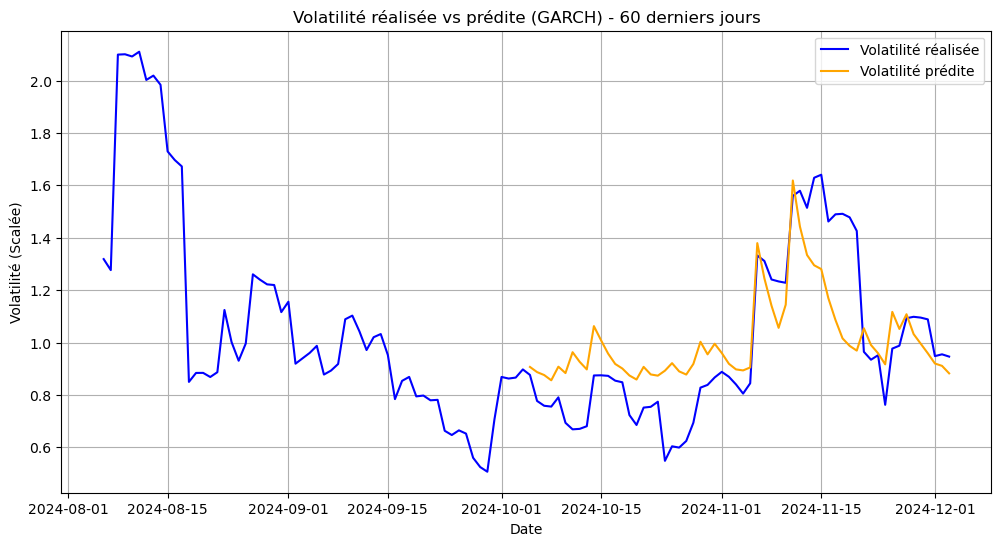

Évaluation des prédictions de volatilité :
Mean Squared Error (MSE): 0.0388
Root Mean Squared Error (RMSE): 0.1971
Mean Absolute Error (MAE): 0.1577
R² Score: 0.5618


In [22]:
# Charger les données
data_d = pd.read_csv('BTCUSDT_daily_2023.csv')  # Remplacez par votre fichier
data_d['timestamp'] = pd.to_datetime(data_d['timestamp'])
data_d.set_index('timestamp', inplace=True)

garch_analysis(data_d,1,1)

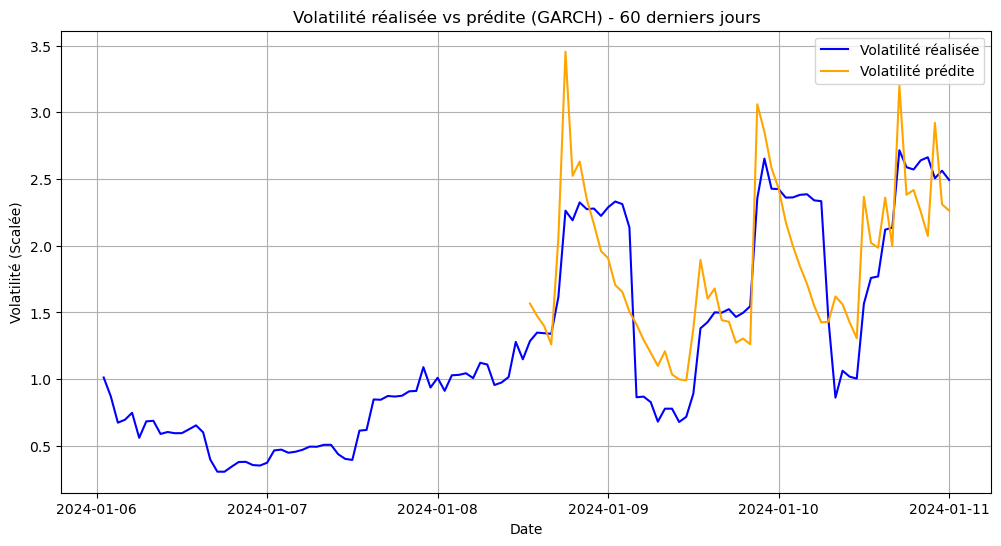

Évaluation des prédictions de volatilité :
Mean Squared Error (MSE): 0.1874
Root Mean Squared Error (RMSE): 0.4329
Mean Absolute Error (MAE): 0.3609
R² Score: 0.5512


In [31]:
# Charger les données
data_h = pd.read_csv('BTCUSDT_hourly_2023.csv')
data_h['timestamp'] = pd.to_datetime(data_h['timestamp'])
data_h.set_index('timestamp', inplace=True)

garch_analysis(data_h,2,2,'t')